# Project 4 - Mc907/Mo651 - Mobile Robotics

### Student:
Luiz Eduardo Cartolano - RA: 183012

### Instructor:
Esther Luna Colombini

### Github Link:
[Project Repository](https://github.com/luizcartolano2/mc907-mobile-robotics)

### Youtube Link:
[Link to Video](https://youtu.be/uqNeEhWo0dA)

### Subject of this Work:
The general objective of this work is to implement a deep learning approach for solve the Visual Odometry problem.

### Goals:
1. Implement and evaluate a Deep VO strategy using images from the [AirSim](https://github.com/microsoft/AirSim) simulator.

In [2]:
import pandas as pd
import glob
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.autograd import Function
from torch.autograd import Variable
from torchvision import models
import torch.optim as optim
import math
from scipy.spatial.transform import Rotation as R
import matplotlib
import matplotlib.pyplot as plt

## Data Pre-Processing

### Clean wrong images

While upload images obtained from the AirSim simulator were noted that some of them had failure, so, we have to clean this data to avoid noise in the dataset.

In [3]:
for dt in ['1','2','3','4','5','6']:
    path = 'dataset/'+'seq'+dt+'/'
    print("-------------------------------------------")
    print('|    '+path)
    all_images = glob.glob(path+'images'+'/*')
    df_poses = pd.read_csv(path+'poses.csv')[['ImageFile']].values
    for img in df_poses:
        if not (path+'images/'+img) in all_images:
            print('|        '+img[0])
    print("-------------------------------------------")          

-------------------------------------------
|    dataset/seq1/
-------------------------------------------
-------------------------------------------
|    dataset/seq2/
-------------------------------------------
-------------------------------------------
|    dataset/seq3/
-------------------------------------------
-------------------------------------------
|    dataset/seq4/
-------------------------------------------
-------------------------------------------
|    dataset/seq5/
-------------------------------------------
-------------------------------------------
|    dataset/seq6/
-------------------------------------------


### Images

In [4]:
def compute_rgb_mean(image_sequence):
    '''
        Compute the mean over each channel separately over a set of images.
        Parameters
        ----------
        image_sequence  :   np.ndarray
                        Array of shape ``(N, h, w, c)`` or ``(h, w, c)``
    '''
    if image_sequence.ndim == 4:
        _, h, w, c = image_sequence.shape
    if image_sequence.ndim == 3:
        h, w, c = image_sequence.shape
    # compute mean separately for each channel
    # somehow this expression is buggy, so we must do it manually
    # mode = image_sequence.mean((0, 1, 2))
    mean_r = image_sequence[..., 0].mean()
    mean_g = image_sequence[..., 1].mean()
    mean_b = image_sequence[..., 2].mean()
    mean = np.array([mean_r, mean_g, mean_b])
    return mean

def mean_normalize(images_vector):
    '''
        Normalize data to the range -1 to 1
    '''
    out_images = []
    
    N = len(images_vector)
    
    print('|    Mean-normalizing ...')

    mean_accumlator = np.zeros((3,), dtype=np.float32)

    for idx in range(N):
        img = images_vector[idx]
        mean_accumlator += compute_rgb_mean(img)

    mean_accumlator /= N
    print(f'|    Mean: {mean_accumlator}')
    
    for idx in range(N):
        img = images_vector[idx]
        out_images.append(img - mean_accumlator)
    
    print('|    Done')
    
    return out_images

In [5]:
def get_image(path,img_size=(256,144)):
    """
        Function to read an image from a given path.
        
        :param: path - image path
        :param: img_size - image size
        
        :return: img - numpy array with the images pixels (converted to grayscale and normalized)
        
    """
    # read image from path
    img = cv2.imread(path)

    # normalize image pixels
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return img

In [6]:
def load_images(img_dir, img_size=(256,144)):

    """
        Function to coordinate the load of all the images that are going to be used.
        
        :param: img_dir - path to the directory containing the images
        :param: img_size - image size
        
        :return: images_set - numpy array with all images at the set
        
    """
    print("----------------------------------------------------------------------")
    print ("|    Loading images from: ", img_dir)
    
    # loop to read all the images of the directory
    images = [get_image(img,img_size) for img in glob.glob(img_dir+'/*')]
    
    # normalize images
    images = mean_normalize(images)
    
    #resemble images as RGB
    images = [img[:, :, (2, 1, 0)] for img in images]
    
    #Transpose the image that channels num. as first dimension
    images = [np.transpose(img,(2,0,1)) for img in images]
    images = [torch.from_numpy(img) for img in images]
    
    #stack per 2 images
    images = [np.concatenate((images[k],images[k+1]),axis = 0) for k in range(len(images)-1)]
        
    print("|    Images count : ",len(images))

    # reshape the array of all images
    images_set = np.stack(images,axis=0)
    print("----------------------------------------------------------------------")

    return images_set

### Pose

The next three functions are used to the Kitti Dataset poses.

In [ ]:
def isRotationMatrix(R):
    """ 
        Checks if a matrix is a valid rotation matrix referred from 
        https://www.learnopencv.com/rotation-matrix-to-euler-angles/
        
        :param: R - rotation matrix
        
        :return: True or False
        
    """
    # calc the transpose
    Rt = np.transpose(R)

    # check identity
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    
    return n < 1e-6

In [ ]:
def rotationMatrixToEulerAngles(R):
    """ 
        Calculates rotation matrix to euler angles
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles
        
        :param: R - rotation matrix
        
        :return: rotation matrix for Euler angles
    """
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [ ]:
def getMatrices(all_poses):
    """
        Function to extract matrices from poses
        
        :param: all_poses - list with all poses from the sequence
        
        :return: all_matrices - list with all matrices obtained from the poses
    """
    all_matrices = []
    for i in range(len(all_poses)):
        #print("I: ",i)
        j = all_poses[i]
        #print("J:   ",j)
        p = np.array([j[3], j[7], j[11]])
        #print("P:   ", p)
        R = np.array([[j[0],j[1],j[2]],
                      [j[4],j[5],j[6]],
                      [j[8],j[9],j[10]]
                     ])
        #print("R:   ", R)
        angles = rotationMatrixToEulerAngles(R)
        #print("Angles: ",angles)
        matrix = np.concatenate((p,angles))
        #print("MATRIX: ", matrix)
        all_matrices.append(matrix)
    return all_matrices

In [ ]:
def load_kitti_images(pose_file):
    poses = []
    poses_set = []

    with open(pose_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            pose = np.fromstring(line, dtype=float, sep=' ')
            poses.append(pose)
    
    poses = getMatrices(poses)
    pose1 = poses[0]
    for i in range(len(poses)-1):
        pose2 = poses[i+1]
        finalpose = np.zeros(pose1)
        poses_set.append(finalpose)

    return poses_set

The next three functions are used for the poses obtained from the AirSim simulator.

In [7]:
def add_pi_to_poses(pose):
    '''Add Pi to every pose angle.'''
    pose += np.pi
    
    return pose

In [8]:
def quat_to_euler_angles(quat_matrix):
    # create a scipy object from the quaternion angles
    rot_mat = R.from_quat(quat_matrix)
    # convert the quaternion to euler (in degrees)
    euler_mat = rot_mat.as_euler('yxz', degrees=False)
    # convert from (-pi,pi) to (0,2pi)
    euler_convert = add_pi_to_poses(euler_mat)
    
    return euler_convert

In [9]:
def load_airsim_pose(pose_file):
    
    poses = []
    poses_set = []
    
    df_poses = pd.read_csv(pose_file)
    for index, row in df_poses.iterrows():
        # get the (x,y,z) positions of the camera
        position = np.array([row['POS_X'],row['POS_Y'],row['POS_Z']])
        # get the quaternions angles of the camera
        quat_matrix = np.array([row['Q_X'],row['Q_Y'], row['Q_Z'],row['Q_W']])
        # call the func that convert the quaternions to euler angles
        euler_matrix = quat_to_euler_angles(quat_matrix)
        # concatenate both position(x,y,z) and euler angles
        poses.append(np.concatenate((position,euler_matrix)))
    
    # make the first pose as start position
    pose1 = poses[0]
    for i in range(len(poses)):
        pose2 = poses[i]
        pose_diff = np.subtract(pose2, pose1)
        pose_diff[4:] = np.arctan2(np.sin(pose_diff[4:]), np.cos(pose_diff[4:]))
        
        poses[i] = pose_diff
    
    # get the desloc between two poses
    for i in range(len(poses)-1):
        pose1 = poses[i]
        pose2 = poses[i+1]

        pose_diff = np.subtract(pose2, pose1)
        pose_diff[4:] = np.arctan2(np.sin(pose_diff[4:]), np.cos(pose_diff[4:]))

        poses_set.append(pose_diff)
        
    return poses_set

In [10]:
def load_poses(pose_file, pose_format='airsim'):
    """
        Function to load the image poses.
        
        :param: pose_file - path to the pose file
        :param: pose_format - where the pose were obtained from (AirSim, VREP, Kitti, etc...)
        
        :return: pose_set - set of the poses for the sequence
    """
    print("----------------------------------------------------------------------")
    print ("|    Pose from: ",pose_file)
    
    if pose_format.lower() == 'kitti':
        poses_set = load_kitti_images(pose_file)
    elif pose_format.lower() == 'airsim':
        poses_set = load_airsim_pose(pose_file)
        
    print("|        Poses count: ",len(poses_set))
    print("----------------------------------------------------------------------")    
    return poses_set

### General

Function that acquire all data that will be used for training.

In [11]:
def VODataLoader(datapath,img_size=(256,144), test=False):
    if test:
        sequences = ['3']
    else:
        sequences = ['1','2','4','5','6']
        
    images_set = []
    odometry_set = []
    
    for sequence in sequences:
        dir_path = os.path.join(datapath,'seq'+sequence)
        image_path = os.path.join(dir_path,'images')
        pose_path = os.path.join(dir_path,'poses.csv')
        print("-----------------------------------------------------------------------")
        print("|Load from: ", dir_path)
        images_set.append(torch.FloatTensor(load_images(image_path,img_size)))
        odometry_set.append(torch.FloatTensor(load_poses(pose_path, 'AirSim')))
        print("-----------------------------------------------------------------------")
    
    print("---------------------------------------------------")
    print("|   Total Images: ", len(images_set))
    print("|   Total Odometry: ", len(odometry_set))
    print("---------------------------------------------------")    
    return images_set, odometry_set

In [12]:
X,y = VODataLoader(datapath='dataset', test=False)

-----------------------------------------------------------------------
|Load from:  dataset/seq1
----------------------------------------------------------------------
|    Loading images from:  dataset/seq1/images
|    Mean-normalizing ...
|    Mean: [0.3115534  0.29183614 0.27286035]
|    Done
|    Images count :  326
----------------------------------------------------------------------
----------------------------------------------------------------------
|    Pose from:  dataset/seq1/poses.csv
|        Poses count:  326
----------------------------------------------------------------------
-----------------------------------------------------------------------
-----------------------------------------------------------------------
|Load from:  dataset/seq2
----------------------------------------------------------------------
|    Loading images from:  dataset/seq2/images
|    Mean-normalizing ...
|    Mean: [0.2615339  0.24993458 0.2350733 ]
|    Done
|    Images count :  283
--

## Data Acquire

Converting lists containing tensors to tensors as per the batchsize (10)

In [13]:
X_train = [item for x in X for item in x]
Y_train = [item for a in y for item in a]

Some info about the training data

In [14]:
print("---------------------------------")
print("Details of X :")
print(type(X_train)) 
print(type(X_train[0]))
print(len(X_train)) 
print(X_train[0].size())
print("---------------------------------")
print("Details of y :")
print(type(Y_train))
print(type(Y_train[0]))
print(len(Y_train))
print(Y_train[0].size())
print("---------------------------------")

---------------------------------
Details of X :
<class 'list'>
<class 'torch.Tensor'>
1306
torch.Size([6, 144, 256])
---------------------------------
Details of y :
<class 'list'>
<class 'torch.Tensor'>
1306
torch.Size([6])
---------------------------------


In [15]:
X_stack = torch.stack(X_train)

In [16]:
y_stack = torch.stack(Y_train)

In [17]:
X_batch = X_stack.view(-1,1,6,144,256)
y_batch = y_stack.view(-1,1,6)

In [18]:
print("Details of X :")
print(X_batch.size())
print("Details of y :")
print(y_batch.size())

Details of X :
torch.Size([1306, 1, 6, 144, 256])
Details of y :
torch.Size([1306, 1, 6])


Split training data into training and validation

In [19]:
validation_split = .2
dataset_size = len(X_batch)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

In [20]:
X_batch_train = X_batch[split:]
y_batch_train = y_batch[split:]
X_batch_validation = X_batch[:split]
y_batch_validation = y_batch[:split]

## Defining DeepVO model

In [21]:
class DeepVONet(nn.Module):
    def __init__(self):
        super(DeepVONet, self).__init__()
        # CNN
        # convolutional layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), #6 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d (64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2), 
        )
        # convolutional layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d (128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 3_1        
        self.conv3_1 = nn.Sequential(
            nn.Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 4_1
        self.conv4_1 = nn.Sequential(
            nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 5
        self.conv5 = nn.Sequential(
            nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 5_1
        self.conv5_1 = nn.Sequential(
            nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
        )
        # convolutional layer 6
        self.conv6 = nn.Sequential(
            nn.Conv2d (512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
        )
        # RNN
        self.lstm1 = nn.LSTMCell(2*6*1024, 100)
        self.lstm2 = nn.LSTMCell(100, 100)
        self.fc = nn.Linear(in_features=100, out_features=6)

        self.reset_hidden_states()

    def reset_hidden_states(self, size=1, zero=True):
        if zero == True:
            self.hx1 = Variable(torch.zeros(size, 100))
            self.cx1 = Variable(torch.zeros(size, 100))
            self.hx2 = Variable(torch.zeros(size, 100))
            self.cx2 = Variable(torch.zeros(size, 100))
        else:
            self.hx1 = Variable(self.hx1.data)
            self.cx1 = Variable(self.cx1.data)
            self.hx2 = Variable(self.hx2.data)
            self.cx2 = Variable(self.cx2.data)

        if next(self.parameters()).is_cuda == True:
            self.hx1 = self.hx1.cuda()
            self.cx1 = self.cx1.cuda()
            self.hx2 = self.hx2.cuda()
            self.cx2 = self.cx2.cuda()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv3_1(x)
        x = self.conv4(x)
        x = self.conv4_1(x)
        x = self.conv5(x)
        x = self.conv5_1(x)
        x = self.conv6(x)

        x = x.view(x.size(0), 2 * 6 * 1024)
        
        self.hx1, self.cx1 = self.lstm1(x, (self.hx1, self.cx1))
        x = self.hx1
        self.hx2, self.cx2 = self.lstm2(x, (self.hx2, self.cx2))
        x = self.hx2
        #print(x.size())
        x = self.fc(x)
        return x


Defines the training function

In [22]:
# creating model
model = DeepVONet()
print(model)

DeepVONet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [23]:
# defining loss and optimizer to be used 
criterion = torch.nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.5)
optimizer = optim.Adagrad(model.parameters(), lr=0.0005)

First we load the pretrained weight of FlowNet ( CNN part ).

In [ ]:
pre_trained = torch.load('flownets_EPE1.951.pth.tar',map_location=torch.device('cpu'))

In [ ]:
update_dict = model.state_dict()

In [ ]:
update_dict['conv1.weight'] = pre_trained['state_dict']['conv1.0.weight']
update_dict['conv2.weight'] = pre_trained['state_dict']['conv2.0.weight']
update_dict['conv3.weight'] = pre_trained['state_dict']['conv3.0.weight']
update_dict['conv4.weight'] = pre_trained['state_dict']['conv4.0.weight']
update_dict['conv4_1.weight'] = pre_trained['state_dict']['conv4_1.0.weight']
update_dict['conv5.weight'] = pre_trained['state_dict']['conv5.0.weight']
update_dict['conv5_1.weight'] = pre_trained['state_dict']['conv5_1.0.weight']
update_dict['conv6.weight'] = pre_trained['state_dict']['conv6.0.weight']


In [ ]:
model.load_state_dict(update_dict)

## Training Model

In [24]:
def training_model(model, train_num, X, y, epoch_num=25):
    start_time = time.time()
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        print("Epoch : ", epoch+1)
        for i in range(train_num):
            print("    Train num :", i+1)
            inputs = X[i]
            print("        Input Size: {}".format(inputs.size()))
            labels = y[i]
            print("        Labels: ",labels)
            
            model.zero_grad()
            model.reset_hidden_states()

            outputs = model(inputs)
            print("        Outputs: ",outputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('    Epoch : %d Loss: %.3f' %(epoch+1, running_loss/train_num))


    print('Finished Training')
    print ("Time taken in Training {0}".format((time.time() - start_time)))

In [25]:
def training_model_v2(model, X_train, y_train, X_validate, y_validate, num_epochs):
    # start model train mode
    train_ep_loss = []
    valid_ep_loss = []
    
    for ep in range(num_epochs):
        st_t = time.time()
        print('='*50)
        
        # Train
        model.train()
        
        loss_mean = 0
        t_loss_list = []
        
        for i in range(X_train.size(0)):
            # get the images inputs
            inputs = X_train[i]
            # get the original poses
            labels = y_train[i]
            # zero optimizer
            optimizer.zero_grad()
            model.reset_hidden_states()
            
            # predict outputs
            outputs = model(inputs)
            # get mse loss
            loss = criterion(outputs, labels)
            ls = loss.item()
            loss.backward()
            # set next optimizer step
            optimizer.step()
            # append loss
            t_loss_list.append(float(ls))
            # update loss
            loss_mean += float(ls)
        
        print('Train take {:.1f} sec'.format(time.time()-st_t))
        loss_mean /= (X_train.size(0))
        train_ep_loss.append(loss_mean)
        
        # Validation
        st_t = time.time()
        model.eval()
        loss_mean_valid = 0
        v_loss_list = []
        
        for i in range(X_validate.size(0)):
            # get the images inputs
            inputs = X_validate[i]
            # get the original poses
            labels = y_validate[i]
            # predict outputs
            outputs = model(inputs)
            # get mse loss
            loss = criterion(outputs, labels)
            ls = loss.item()
            # update loss values
            v_loss_list.append(float(ls))
            loss_mean_valid += float(ls)
        
        print('Valid take {:.1f} sec'.format(time.time()-st_t))
        loss_mean_valid /= X_validate.size(0)
        valid_ep_loss.append(loss_mean_valid)
        
        print('Epoch {}\ntrain loss mean: {}, std: {:.2f}\nvalid loss mean: {}, std: {:.2f}\n'.format(ep+1, loss_mean, np.std(t_loss_list), loss_mean_valid, np.std(v_loss_list)))
        
    return train_ep_loss, valid_ep_loss

Start training

In [26]:
train_loss, valid_loss = training_model_v2(model, X_batch_train, y_batch_train, X_batch_validation, y_batch_validation, 30)

Train take 535.4 sec
Valid take 20.4 sec
Epoch 1
train loss mean: 0.6120069708051606, std: 1.42
valid loss mean: 0.5037028984063201, std: 0.97

Train take 480.4 sec
Valid take 20.6 sec
Epoch 2
train loss mean: 0.6020250072106763, std: 1.38
valid loss mean: 0.5382052420627796, std: 0.92

Train take 425.7 sec
Valid take 20.0 sec
Epoch 3
train loss mean: 0.5784835852024204, std: 1.32
valid loss mean: 0.6847623754506824, std: 0.88

Train take 421.5 sec
Valid take 20.2 sec
Epoch 4
train loss mean: 0.5806255663086718, std: 1.33
valid loss mean: 0.71781809787869, std: 0.87

Train take 429.4 sec
Valid take 20.4 sec
Epoch 5
train loss mean: 0.572138224961626, std: 1.28
valid loss mean: 0.5061345360530861, std: 0.91

Train take 438.7 sec
Valid take 21.1 sec
Epoch 6
train loss mean: 0.5497456811983963, std: 1.25
valid loss mean: 0.6617304085828792, std: 0.87

Train take 430.2 sec
Valid take 19.8 sec
Epoch 7
train loss mean: 0.5435410701305468, std: 1.22
valid loss mean: 0.6577828827945665, std: 0

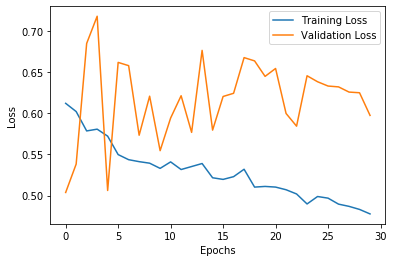

In [27]:
plt.plot(list(range(30)),train_loss, label='Training Loss')
plt.plot(list(range(30)),valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images_model/train_batch_dropout_30.png')
plt.show()

In [28]:
backup_loss = [train_loss, valid_loss]

## Test Model

In [ ]:
def testing_model (model, test_num, X):
    start_time = time.time()
    Y_output = []
    count = 0
    totcount = 0

    model.eval()
    
    for i in range(test_num):
            # get the inputs
            inputs = X[i]
            outputs = model(inputs)
            Y_output.append(outputs)

    print ("Time taken in Testing {0}".format((time.time() - start_time)))
    return torch.stack(Y_output)

In [ ]:
X,y = VODataLoader(datapath='dataset', test=True)

In [ ]:
X[0] = X[0].view(-1,1,6,144,256)

In [ ]:
X[0].size()

In [ ]:
y_out = testing_model(model,X[0].size(0),X[0])

In [ ]:
y = y[0].view(-1,1,6)

In [ ]:
y.shape

In [ ]:
y_out.shape

## Evaluate Model
Accuracy functions

In [ ]:
#Helper functions to get accuracy
def get_accuracy(outputs, labels, batch_size):
    diff =0
    for i in range(batch_size):
        out = (outputs[i].detach().numpy())[0]
        lab = (labels[i].detach().numpy())[0]

        diff+=get_mse_diff(out,lab)
        
    print("Accuracy : ",(1 -diff/(batch_size))*100,"%")
    
def get_mse_diff(x,y):
    diff= 0
    for i in range(6):
        diff += (x[i]-y[i]) ** 2
    return diff/6

In [ ]:
get_accuracy(y_out, y, 497)

## Save Model

In [29]:
torch.save(model.state_dict(), 'model/deepvo-dropout.pt')

## Plotting Odometry

In [ ]:
# (outputs[j].detach().numpy())[0]
x_ori = []
y_ori = []
for i in range(1,len(y)):
    out = y[i]
    out = (out.detach().numpy())[0]
    x_ori.append(out[0])
    y_ori.append(out[0])    
#     x_ori.append(x_ori[i-1] + out[0])
#     y_ori.append(y_ori[i-1] + out[1])

In [ ]:
x_o = []
y_o = []
for i in range(len(y_out)):    
    out = y_out[i]
    out = (out.detach().numpy())[0]
    x_o.append(out[0])
    y_o.append(out[1])
#     x_o.append(x_o[i-1] + out[0])
#     y_o.append(y_o[i-1] + out[1])

In [ ]:
plt.scatter(np.cumsum(x_ori),np.cumsum(y_ori))
plt.scatter(x_ori[0],y_ori[0],marker='x')

In [ ]:
plt.scatter(np.cumsum(x_o),np.cumsum(y_o))
plt.scatter(x_o[0],y_o[0],marker='x')